# imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from numpy import pi

# data extraction

In [2]:
PosVel_read = open('Velocidad.txt','r')
PosVel_split = [line.split(',') for line in PosVel_read.readlines()]

# data cleaning

In [4]:
#Feature extraction for both velocity and position
iteration = 0 #Iteration
rcount = 1    #Row number

while rcount <len(PosVel_split):
    
    if iteration==0:
        if (rcount-(6*iteration))==1:
            Vel_array = np.array([PosVel_split[rcount][11],
                                  PosVel_split[rcount][13],
                                  PosVel_split[rcount][14],
                                  PosVel_split[rcount][15]])
    
        elif (rcount-(6*iteration))==4:
            Pos_array = np.array([PosVel_split[rcount][13],
                                  PosVel_split[rcount][14],
                                  PosVel_split[rcount][15],
                                  PosVel_split[rcount][18],
                                  PosVel_split[rcount][19],
                                  PosVel_split[rcount][20]])
            iteration += 1
            
    else:
        if (rcount-(6*iteration))==1:
            Vel_array = np.vstack([Vel_array,[PosVel_split[rcount][11],
                                  PosVel_split[rcount][13],
                                  PosVel_split[rcount][14],
                                  PosVel_split[rcount][15]]])
    
        elif (rcount-(6*iteration))==4:
            Pos_array = np.vstack([Pos_array,[PosVel_split[rcount][13],
                                  PosVel_split[rcount][14],
                                  PosVel_split[rcount][15],
                                  PosVel_split[rcount][18],
                                  PosVel_split[rcount][19],
                                  PosVel_split[rcount][20]]])
            iteration += 1
            
            
    rcount+=3
    
#Conversion to type float64
    
Pos_array = Pos_array.astype('float64')
Vel_array = Vel_array.astype('float64')


#Data cleaning - Data that equals to zero must be removed, in this case we have 3 bad data points

iteration = 0
a = []

while iteration<len(Pos_array):

    if (Pos_array[iteration][0]==0.0) or (Pos_array[iteration][1]==0.0):  #We detect North or East equal to zero     
        a.append(iteration)
        #print(iteration)

    iteration +=1
    
Pos_array = np.delete(Pos_array,a,0)
Vel_array = np.delete(Vel_array,a,0)

# exploratory data analysis

In [6]:
#Data Frame Creation

Pos_DataFrame = pd.DataFrame(Pos_array,[np.arange(0,len(Pos_array))],['North','East','Height','N_dev','E_dev'
                                                            ,'Hei_dev'])

Vel_DataFrame = pd.DataFrame(Vel_array,[np.arange(0,len(Pos_array))],['Latency','Hspeed','TrackDir','Vspeed'])


#Add total speed. We set if it is 2D or 3D mode

Mode_3D = False    

Vel_DataFrame['Total_Speed'] = ((Vel_DataFrame['Hspeed']**2)+(Mode_3D*Vel_DataFrame['Vspeed']**2))**(1/2)


#Vector

Vector = Pos_DataFrame[['North','East']]
Vector['Total_Speed'] = Vel_DataFrame['Total_Speed']

Vector_array = Vector.to_numpy()


#Vector_errors

Vector_errors = Pos_DataFrame[['N_dev','E_dev']]
Vector_errors['Vel_dev'] = 0

Vector_err_array = Vector_errors.to_numpy()

C:\Users\manu-\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\manu-\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# kalman filter

In [9]:
#We construct the different matrices and the initial state

measurements = len(Pos_array)
dt = Vel_array.mean(axis=0)[0]
repeat = 0
flag_repeat = False

alpha = Vel_array[0][2]*(pi/180)
state = np.array([[Vector_array[0][0]],[Vector_array[0][1]],[Vector_array[0][2]*(np.sin((pi/2)-alpha))],[Vector_array[0][2]*(np.cos((pi/2)-alpha))],[0],[0]])  #Initial state

A = np.array([[1.0,0.0,dt,0.0,0.5*(dt**2),0.0],                    #Transformation Matrix
              [0.0,1.0,0.0,dt,0.0,0.5*(dt**2)],
              [0.0,0.0,1.0,0.0,dt,0.0],
              [0.0,0.0,0.0,1.0,0.0,dt],
              [0.0,0.0,0.0,0.0,1,0.0],
              [0.0,0.0,0.0,0.0,0.0,1]])

#B = np.array([[0.005,0,0.0005,0,10000,0],              #Noise matrix
#              [0,0.005,0,0.0005,0,10000],
#              [0,0,0.00001,0,0,0],
#              [0,0,0,0.00001,0,0],
#              [0,0,0,0,0,100],
#              [0,0,0,0,0,100]])

B = np.array([[0.0015,0,16500,0,0,0],              #Noise matrix
              [0,0.045,0,12500,0,0],
              [0,0,1,0,0,0],
              [0,0,0,1,0,0],
              [0,0,0,0,1,0],
              [0,0,0,0,0,1]])

B = B*((10)**(-6))

P = (np.diag([Vector_err_array[0][0],Vector_err_array[0][1],1,1,1,1]))**2         #Initial state covariance

factor = 8.8
G = np.array([[0.5*(dt**2)],[0.5*(dt**2)],[1*dt],[1*dt],[1],[1]])
Q = (G@G.T)*((factor)**2)

H = np.array([[0,0,1,0,0,0],             #Measurement observation matrix
              [0,0,0,1,0,0]])

R = np.array([[100,0],
              [0,100]])

I = np.eye(6)




#ACTION!!

for epoch in range(measurements):
  
    #RESET. There is an error with the GNSS system and we have to avoid it. Overcome the singularity.
        
    if((Vector_array[epoch][0]!=Vector_array[epoch-1][0])and(Vector_array[epoch][1]!=Vector_array[epoch-1][1])and(Vector_array[epoch][2]!=Vector_array[epoch-1][2])):
        flag_repeat = False
        
    else:  
        flag_repeat = True
        
    
    if( (repeat > 15) and (flag_repeat == False)):    #Reset the filter when repeated 11 times the same measure and in measure different  
        alpha = Vel_array[epoch][2]*(pi/180)
        state = np.array([[Vector_array[epoch][0]],[Vector_array[epoch][1]],[Vector_array[epoch][2]*(np.sin((pi/2)-alpha))],[Vector_array[epoch][2]*(np.cos((pi/2)-alpha))],[0],[0]])
    
        P = (np.diag([Vector_err_array[epoch][0],Vector_err_array[epoch][1],1,1,1,1]))**2
        
        repeat = 0    
    
    if epoch > 0:
        if((Vector_array[epoch][0]==Vector_array[epoch-1][0])and(Vector_array[epoch][1]==Vector_array[epoch-1][1])and(Vector_array[epoch][2]==Vector_array[epoch-1][2])):
            repeat += 1

        else:
            repeat = 0
    
    
    #PREDICTION
    
    state = A@state + B@state    
    P = A@P@A.T + Q
    
    
    #CORRECTION
    
    S = H@P@H.T + R 
    K = P@H.T@np.linalg.inv(S)
    
    alpha = Vel_array[epoch][2]*(pi/180)  
    Z = np.array([[Vector_array[epoch][2]*(np.sin((pi/2)-alpha))],
                  [Vector_array[epoch][2]*(np.cos((pi/2)-alpha))]])
  
    state = state + (K@(Z - H@state))
    
    P = (I - (K@H))@P
    
    
    #PLOTTING
    
    if epoch==0:      
        Prediction_array = np.array([state[0][0],state[1][0]])
        
    else: 
        Prediction_array = np.vstack([Prediction_array,[state[0][0],state[1][0]]])

    
#We save the results
    
Prediction_DataFrame = pd.DataFrame(Prediction_array,[np.arange(0,len(Prediction_array))],['North_Prediction(x)', 'South_Prediction(y)'])

# results visualisation

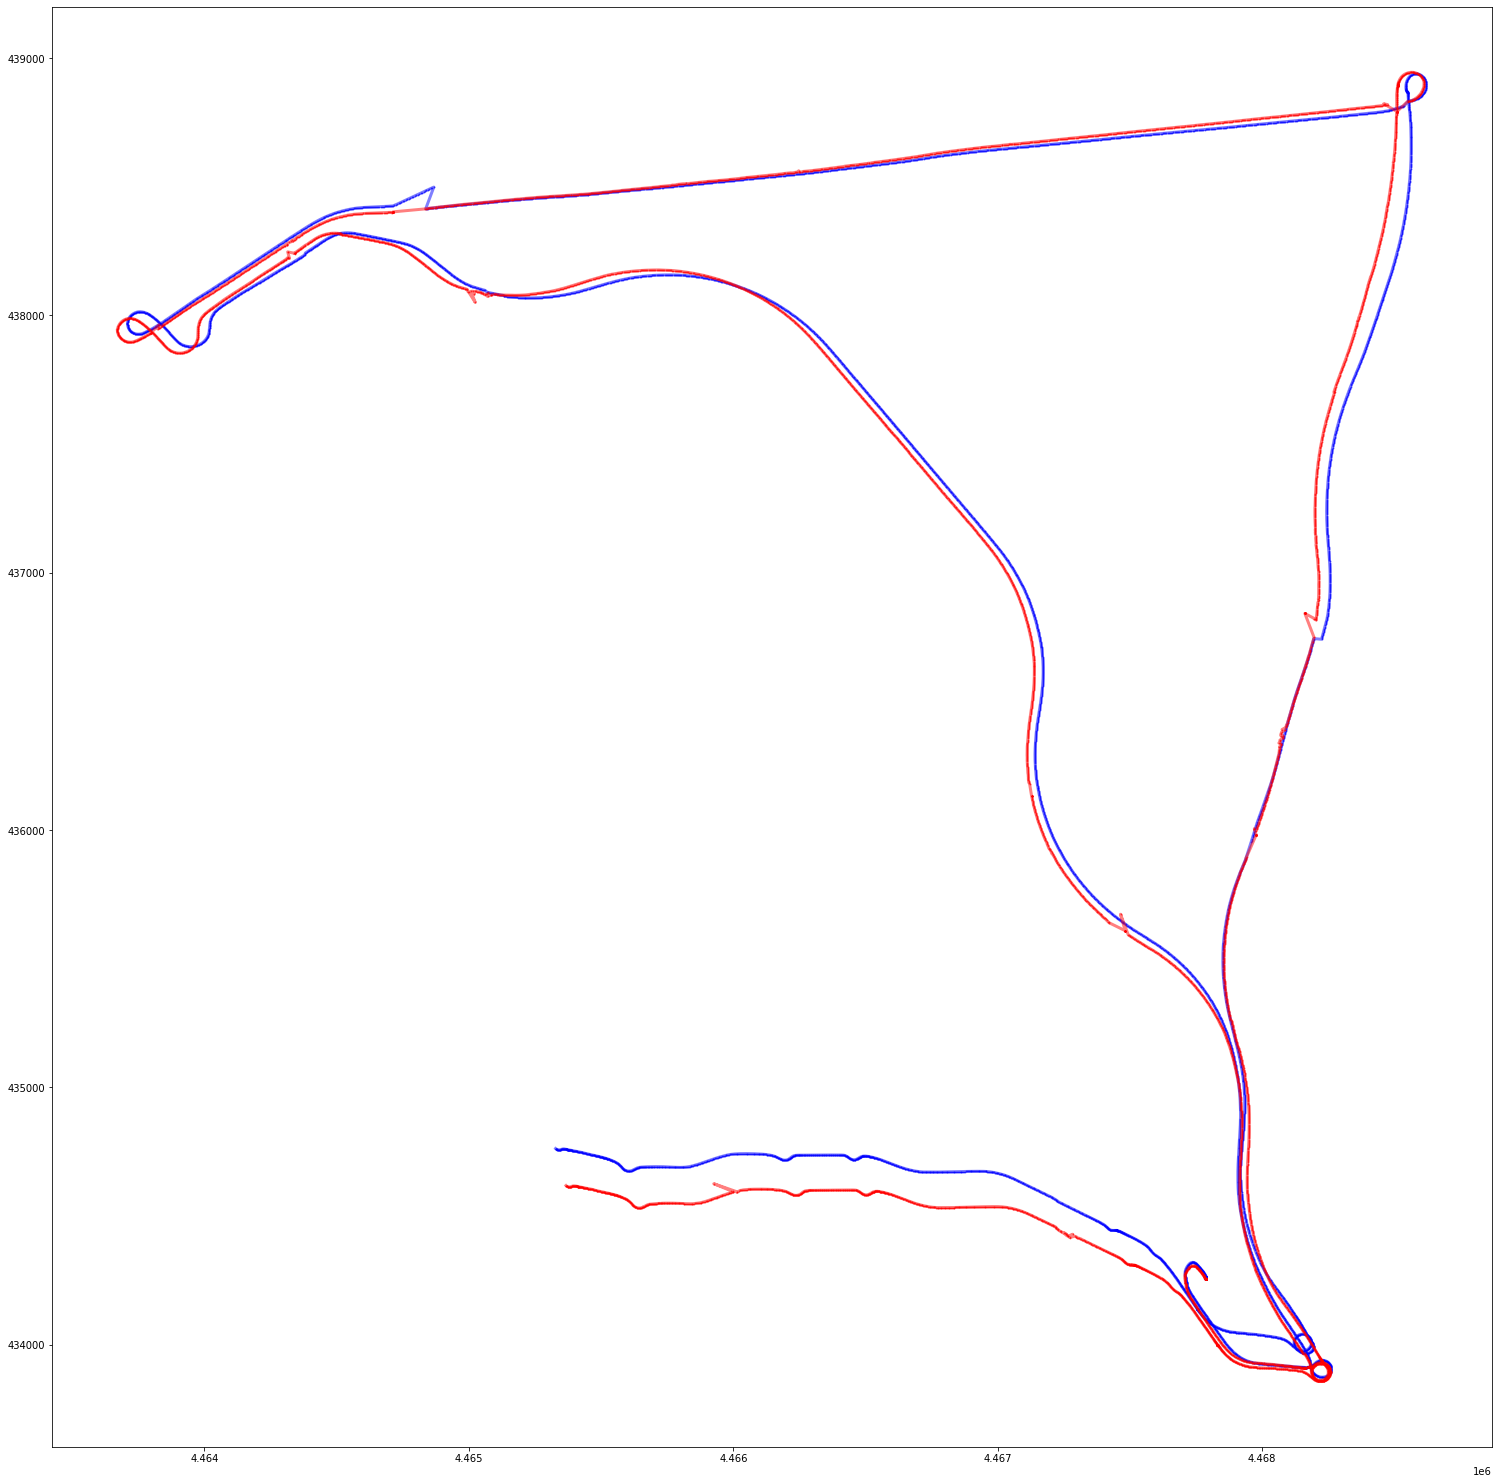

In [10]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame['North_Prediction(x)'],Prediction_DataFrame['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=1,label='Prediction')
ax.plot(Pos_DataFrame['North'],Pos_DataFrame['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=1,label='Data')

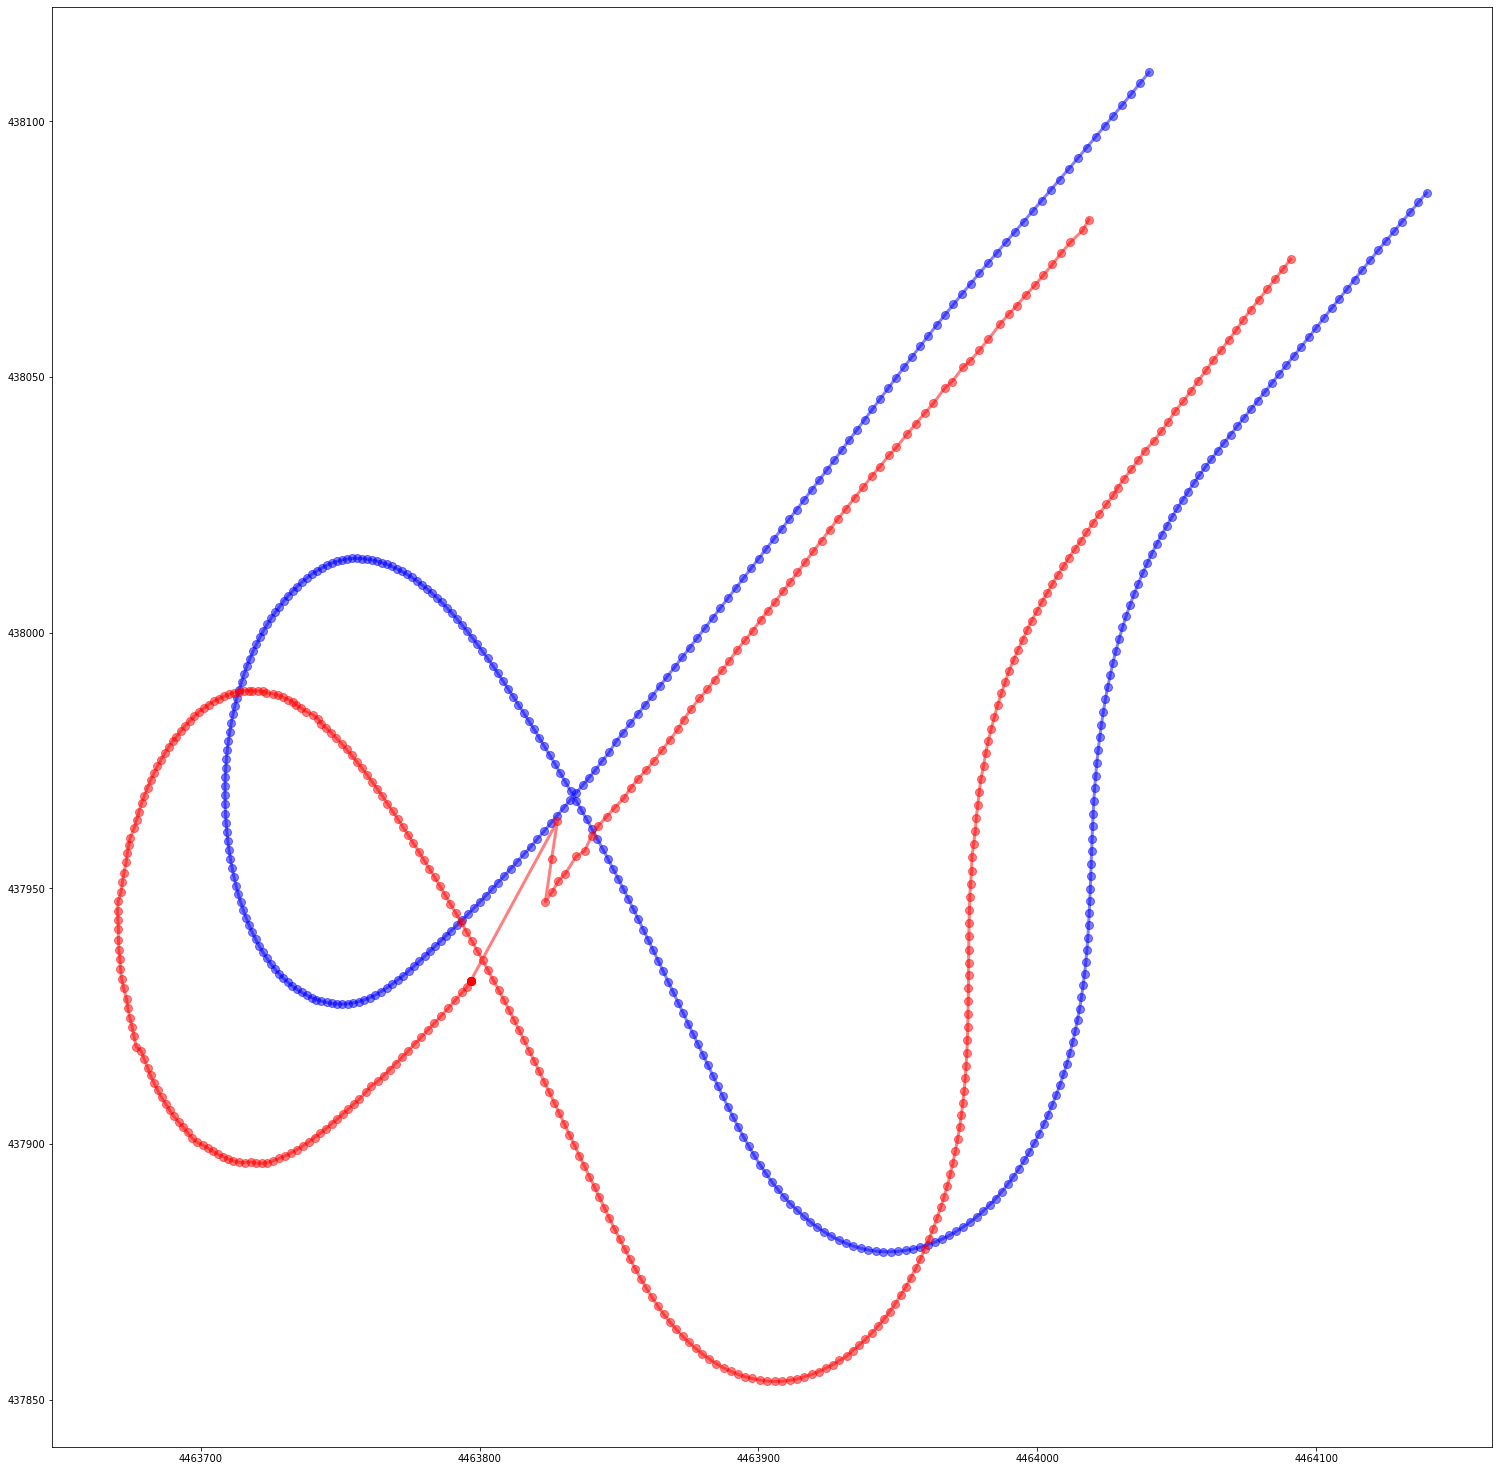

In [11]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[2850:3250]['North_Prediction(x)'],Prediction_DataFrame[2850:3250]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[2850:3250]['North'],Pos_DataFrame[2850:3250]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

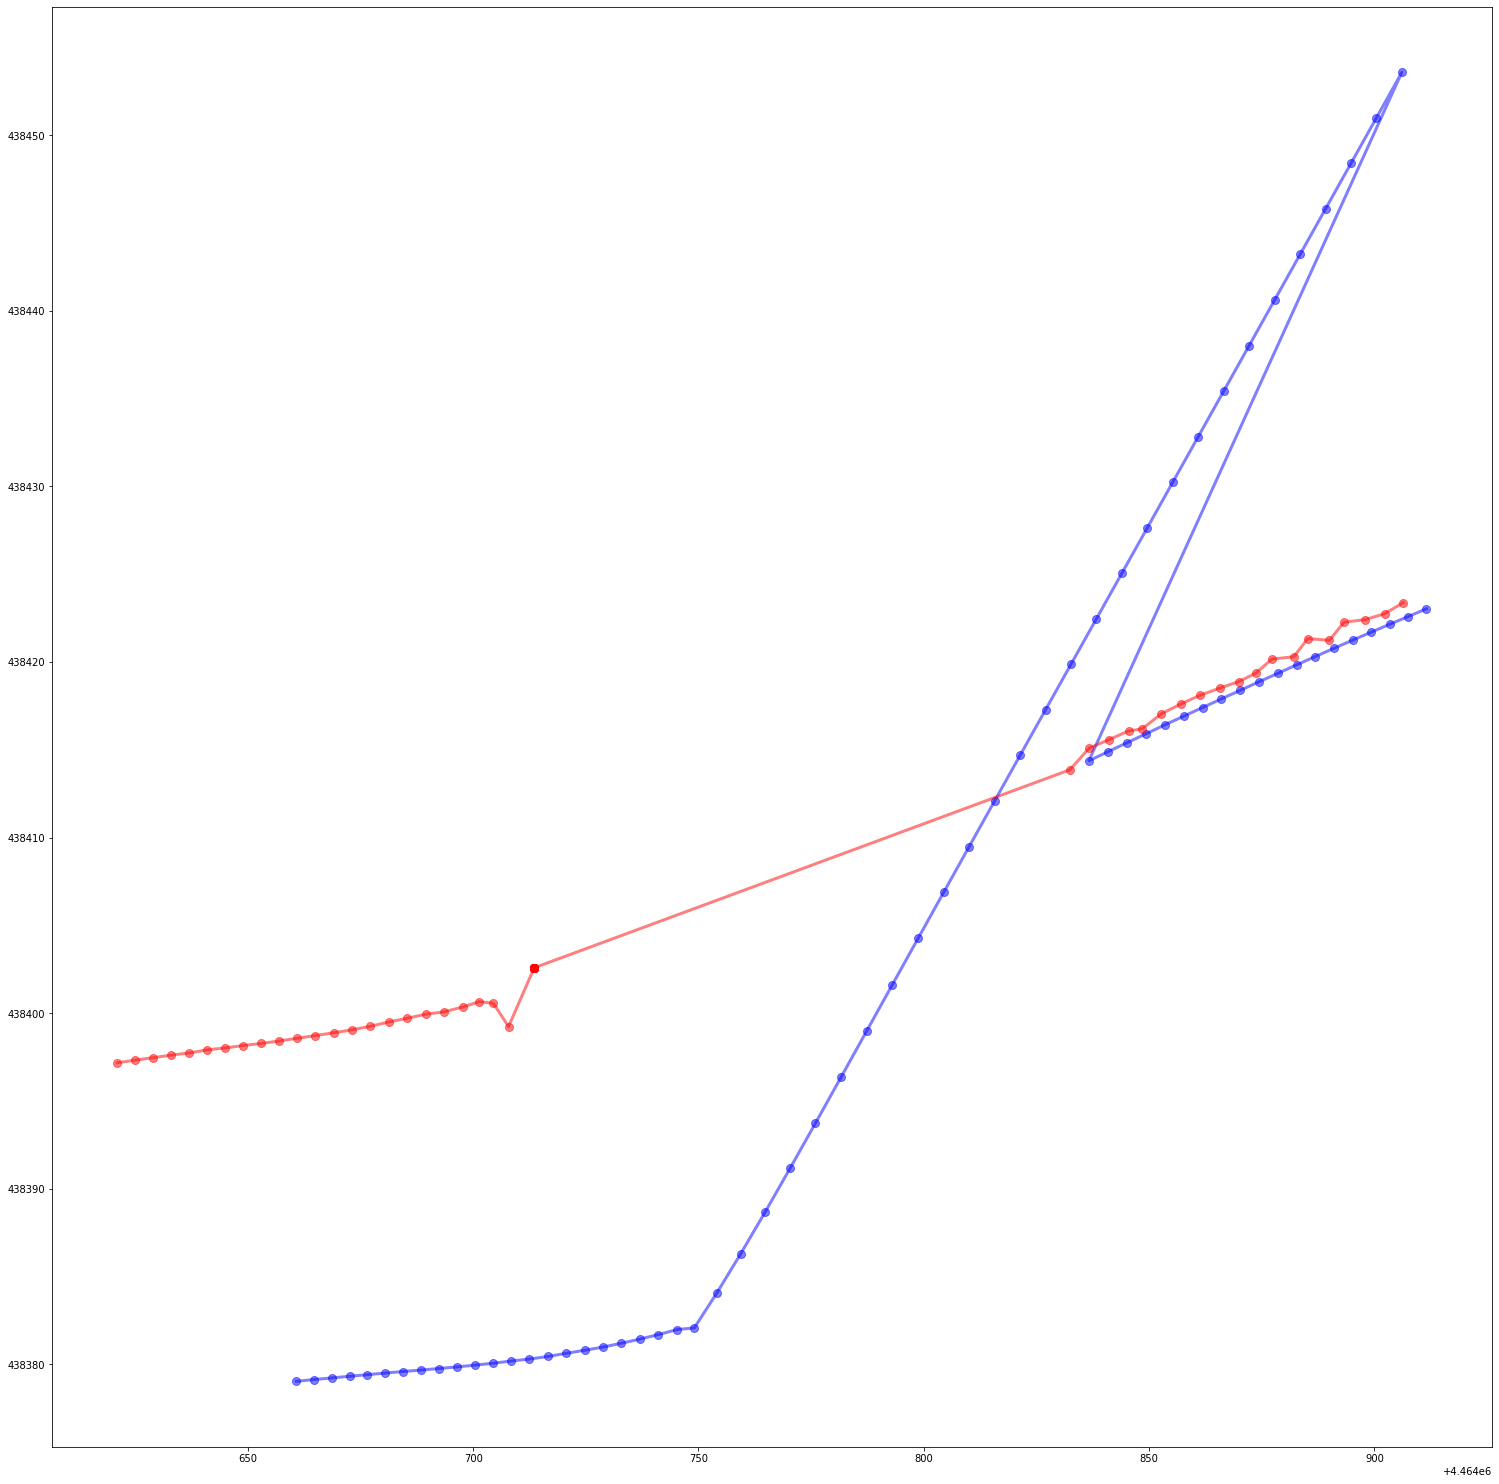

In [22]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[3420:3490]['North_Prediction(x)'],Prediction_DataFrame[3420:3490]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[3420:3490]['North'],Pos_DataFrame[3420:3490]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

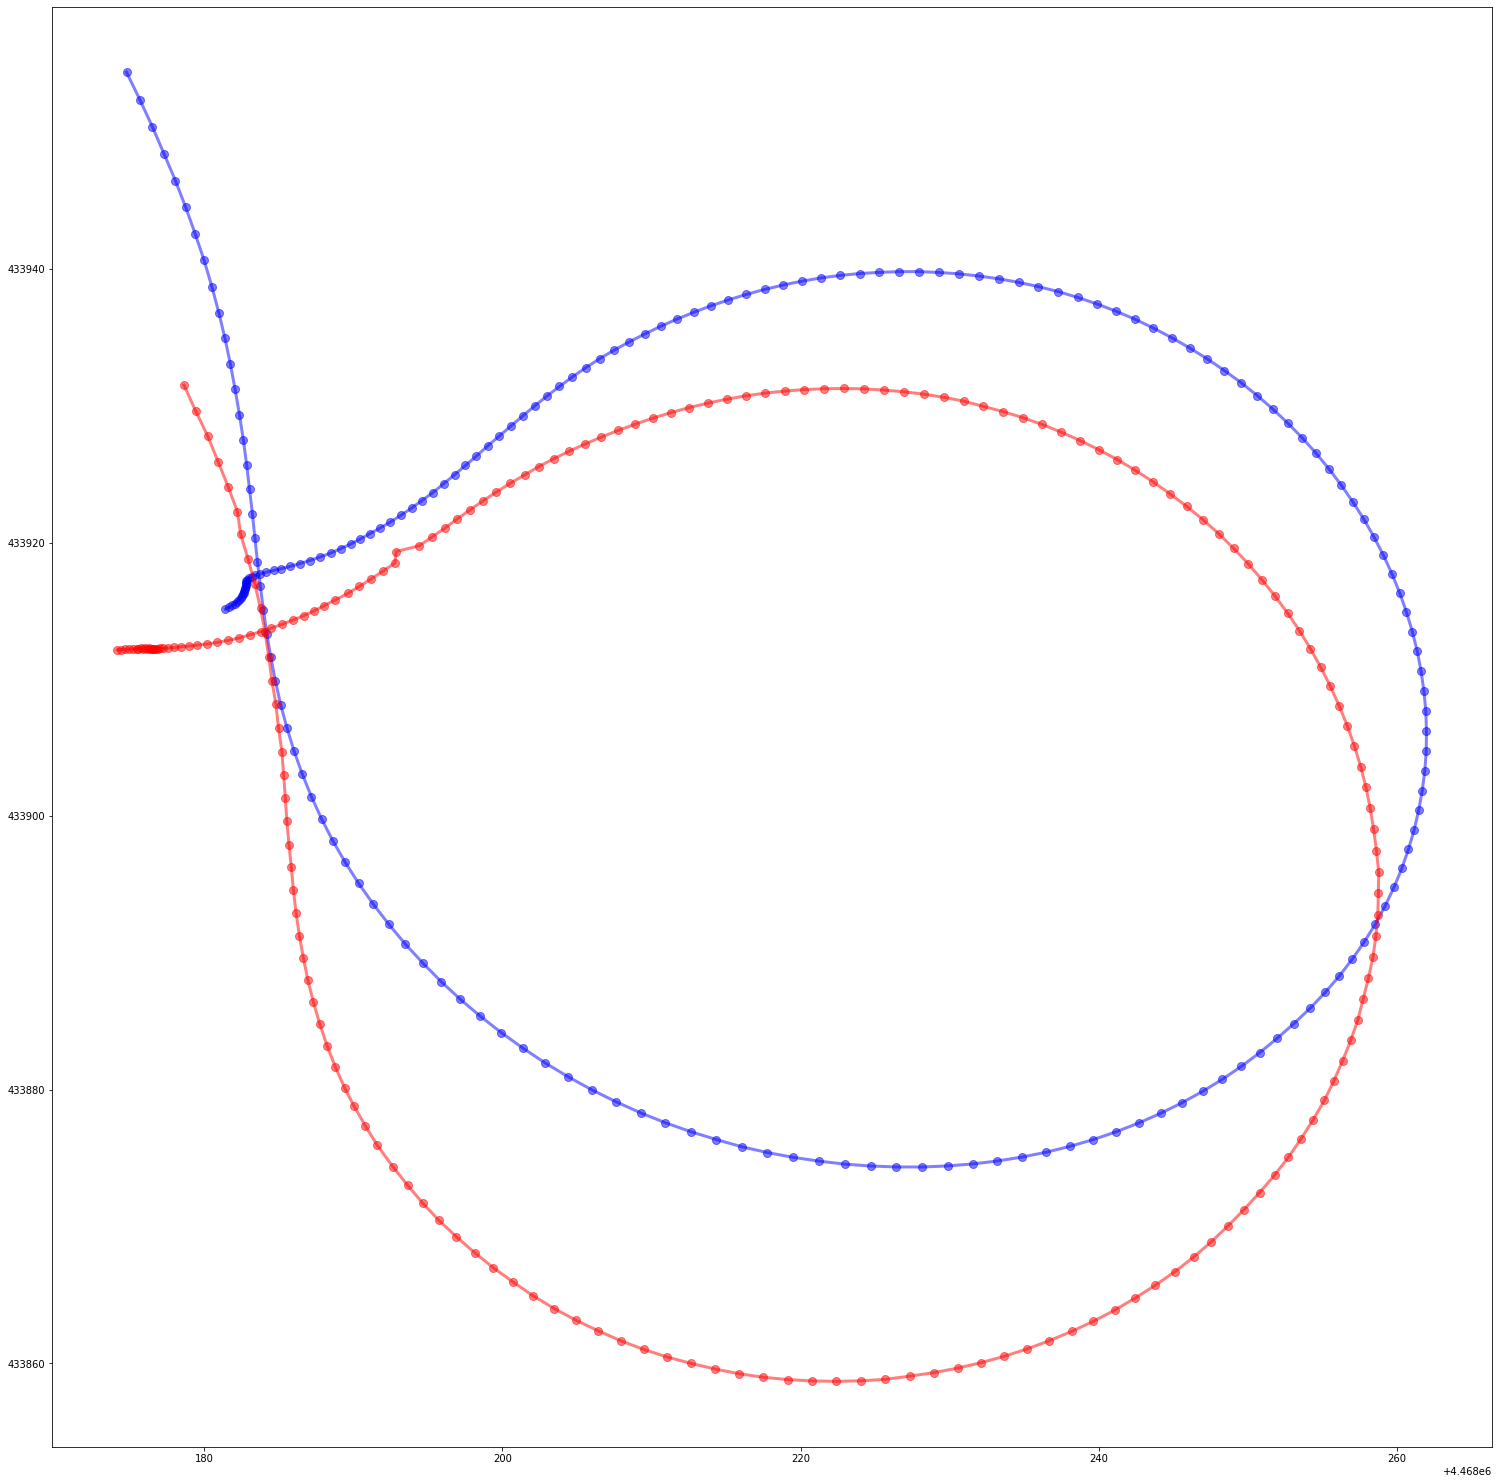

In [12]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[800:1000]['North_Prediction(x)'],Prediction_DataFrame[800:1000]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[800:1000]['North'],Pos_DataFrame[800:1000]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

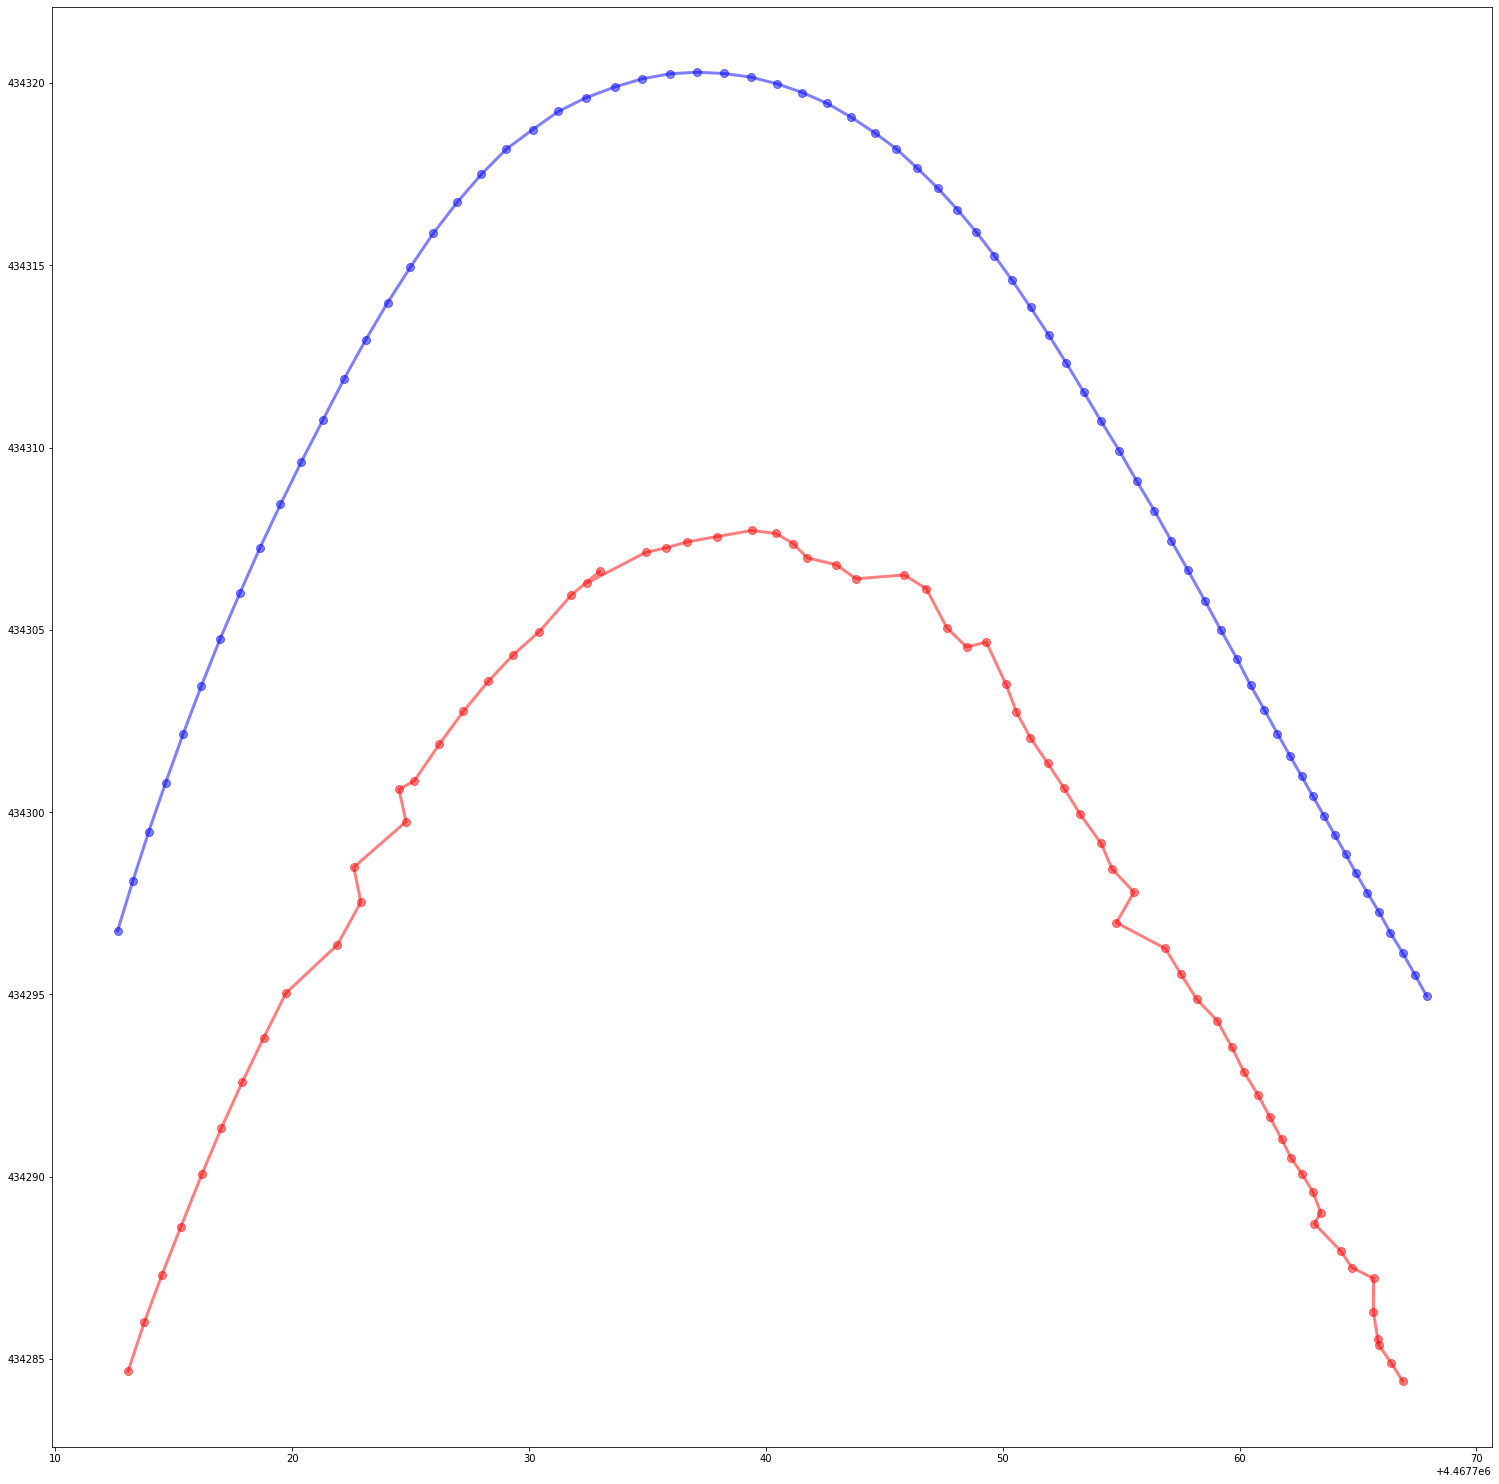

In [25]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[390:460]['North_Prediction(x)'],Prediction_DataFrame[390:460]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[390:460]['North'],Pos_DataFrame[390:460]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

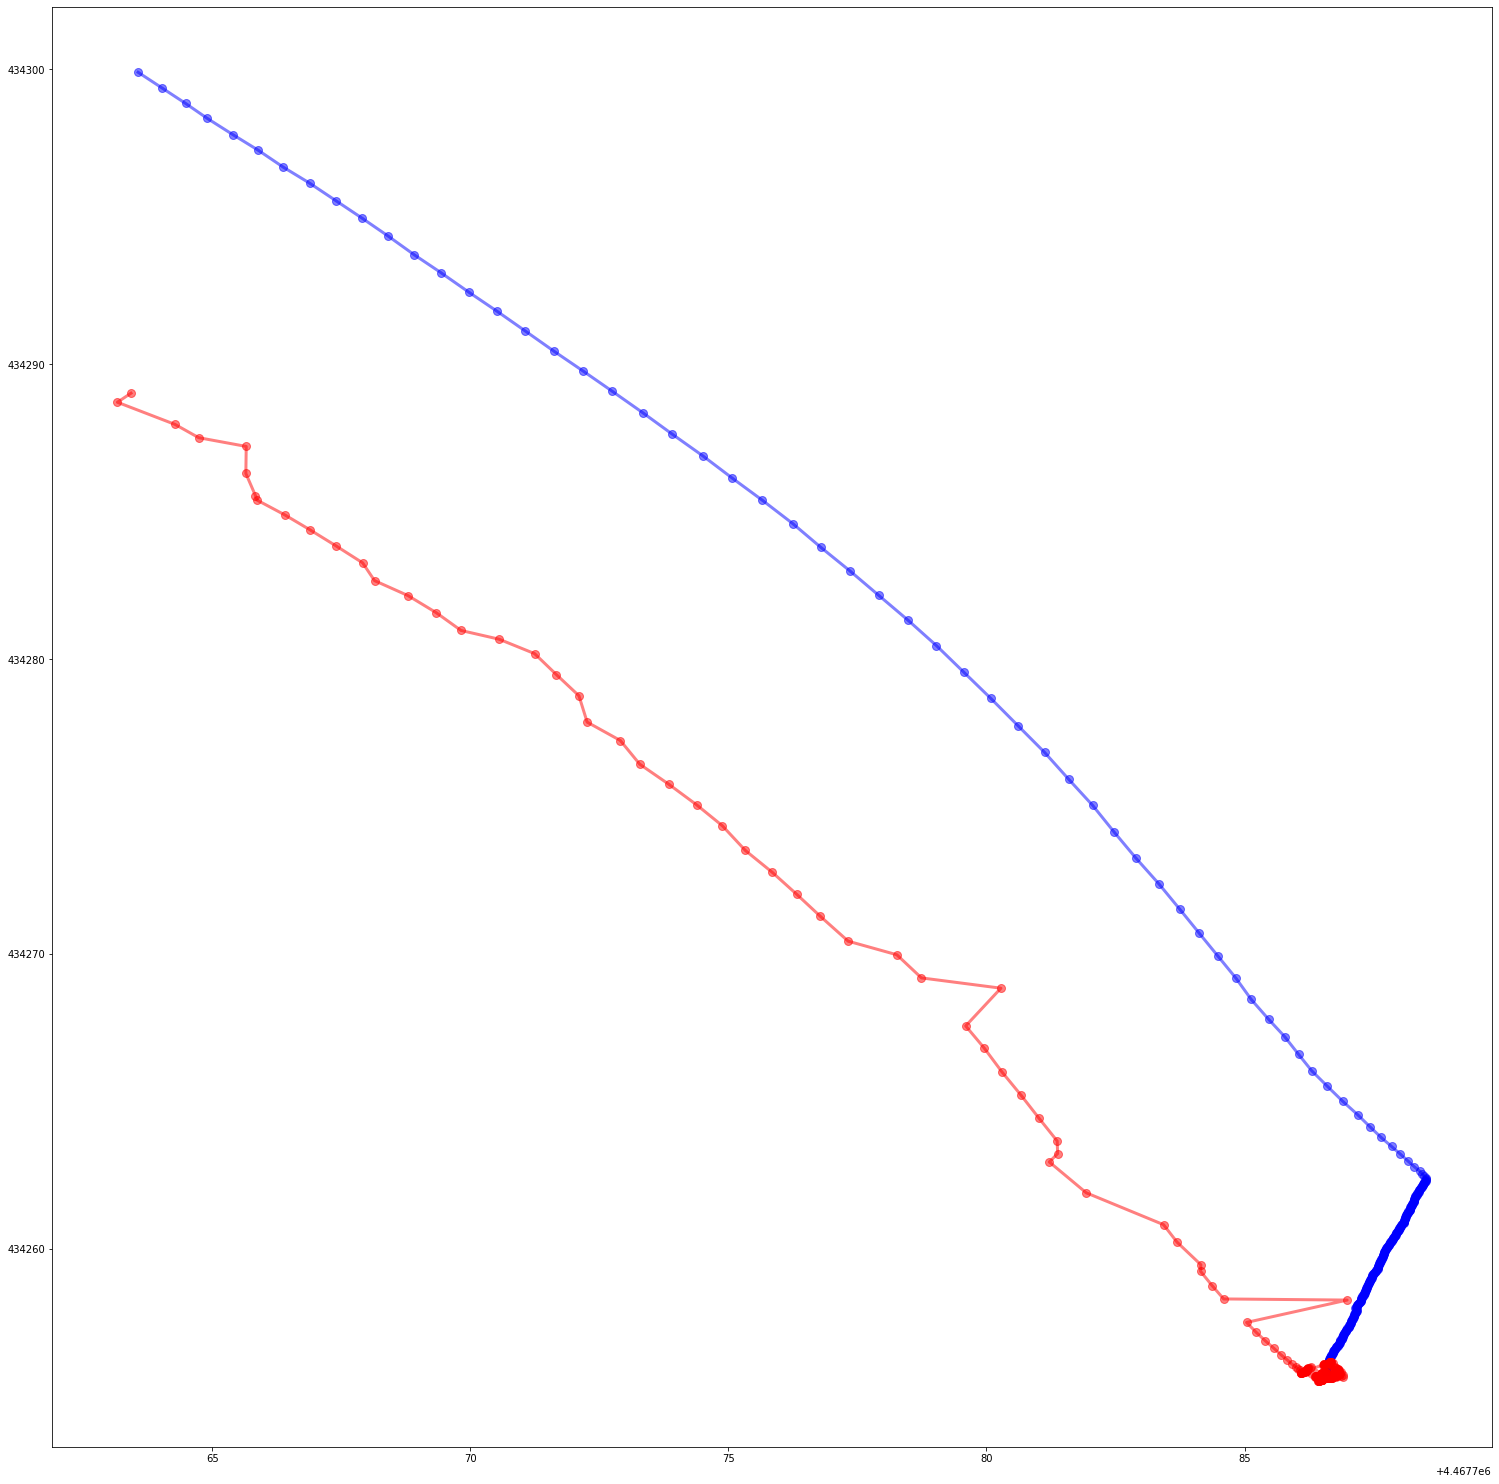

In [26]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[0:400]['North_Prediction(x)'],Prediction_DataFrame[0:400]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[0:400]['North'],Pos_DataFrame[0:400]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

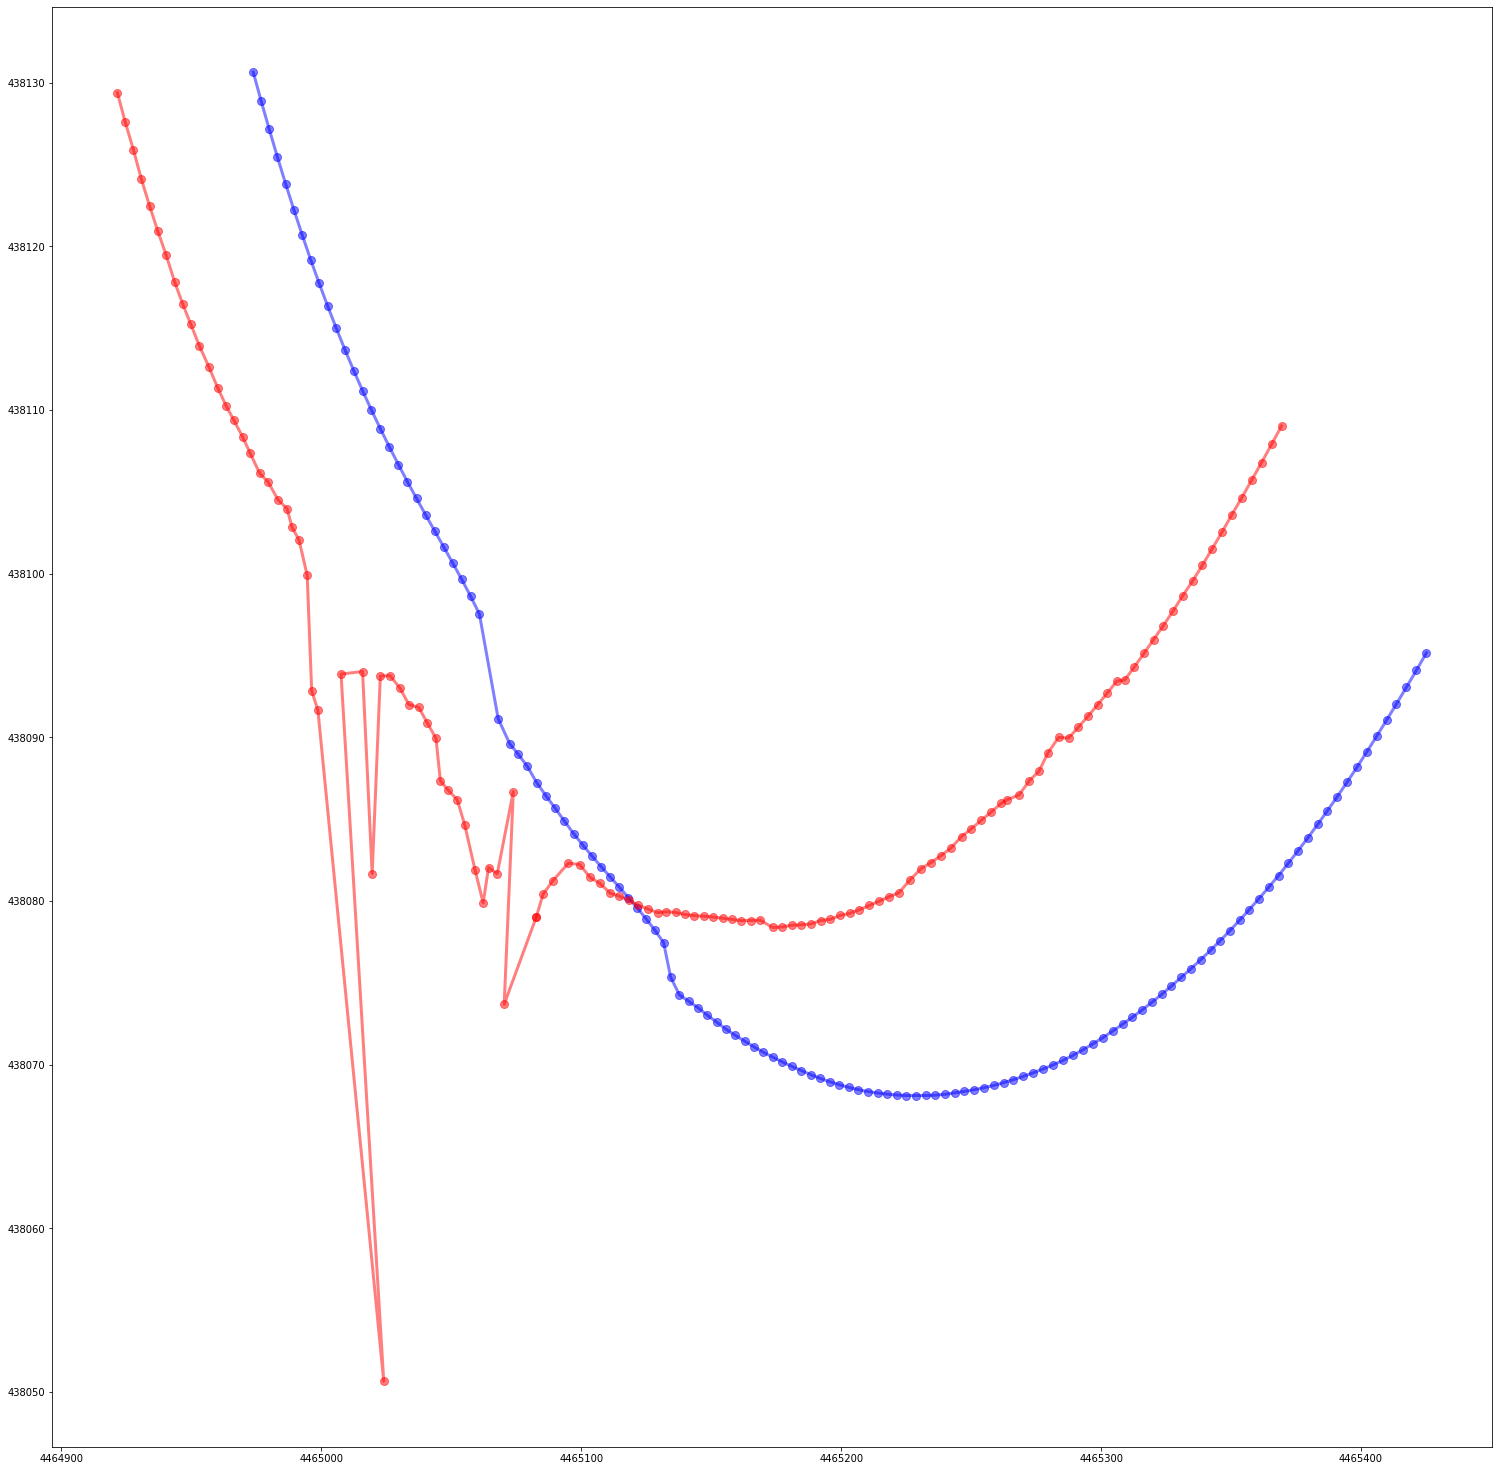

In [29]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[2420:2545]['North_Prediction(x)'],Prediction_DataFrame[2420:2545]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[2420:2545]['North'],Pos_DataFrame[2420:2545]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

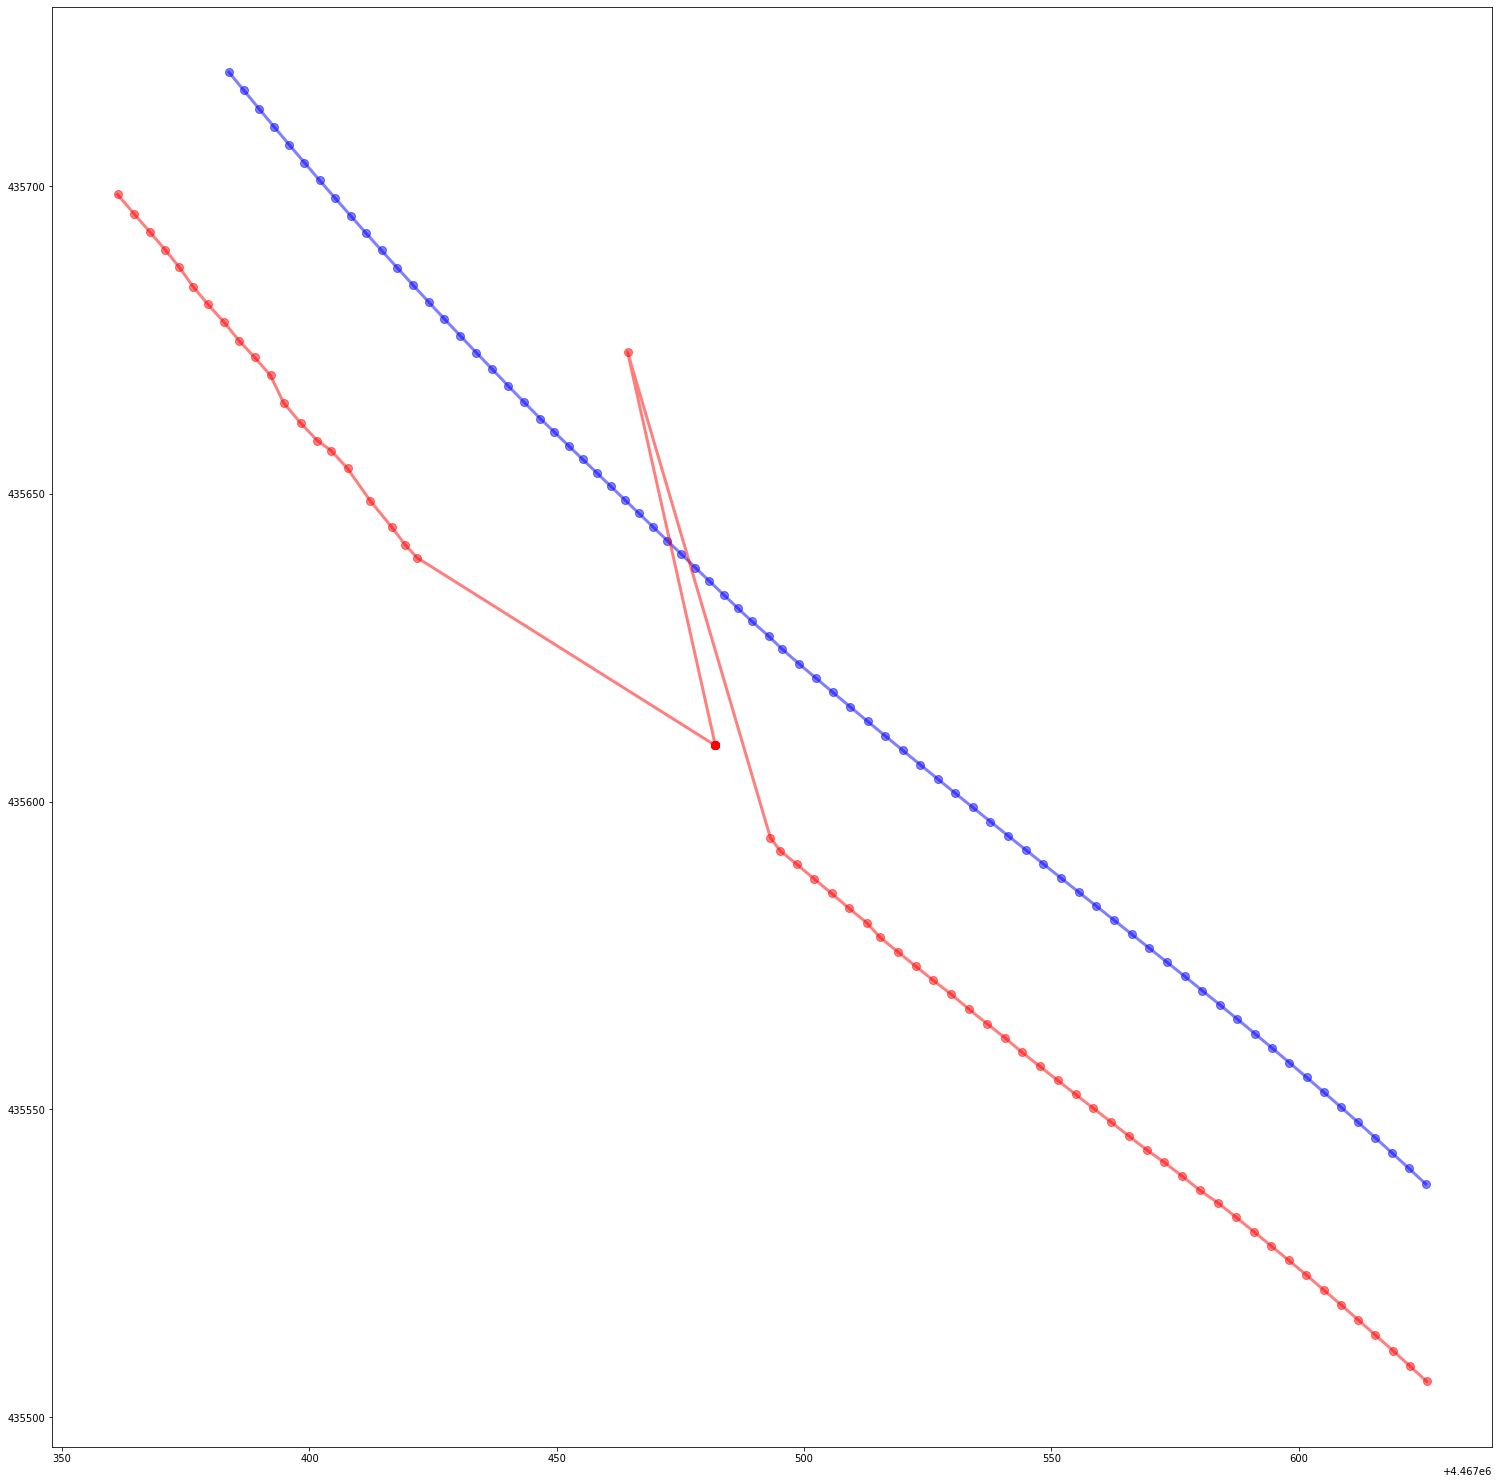

In [44]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[1475:1550]['North_Prediction(x)'],Prediction_DataFrame[1475:1550]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[1475:1550]['North'],Pos_DataFrame[1475:1550]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

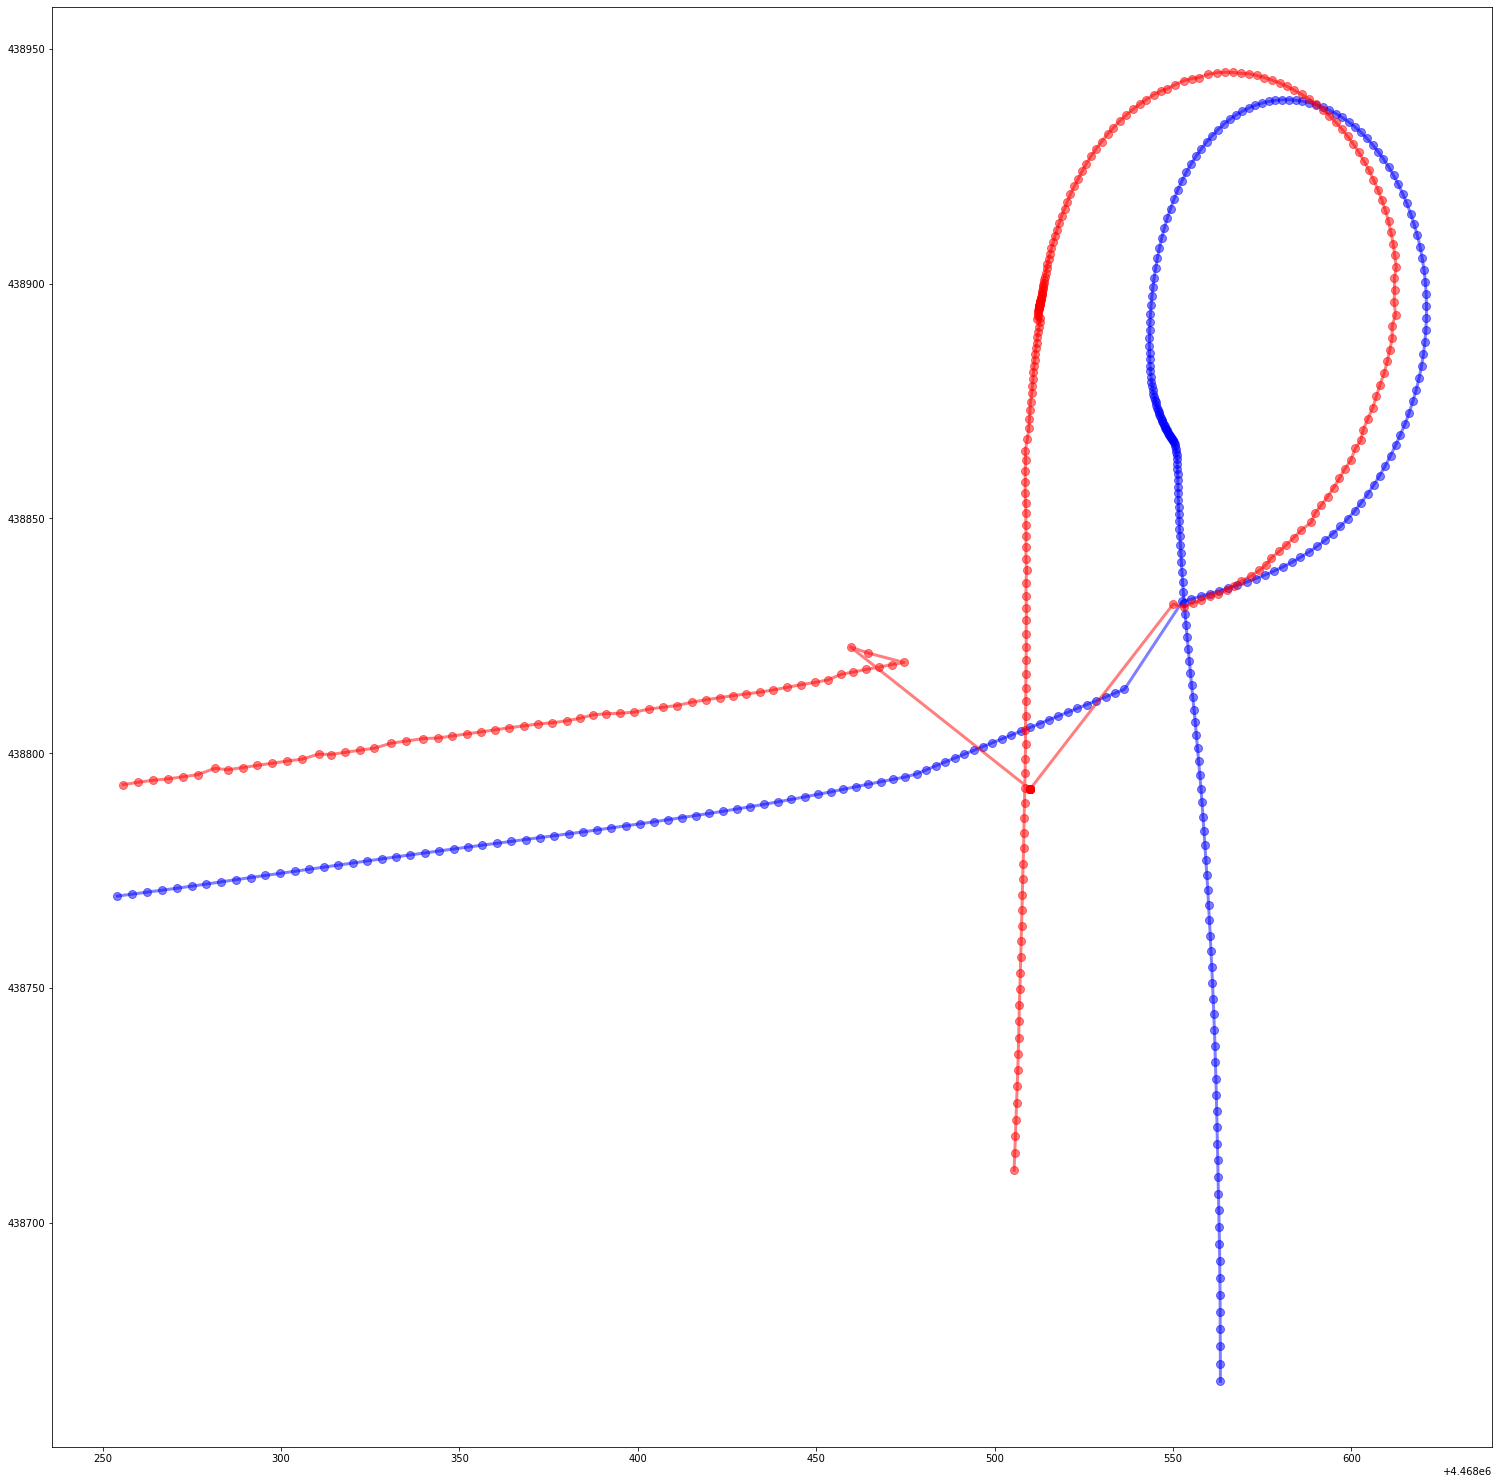

In [52]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[4300:4600]['North_Prediction(x)'],Prediction_DataFrame[4300:4600]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[4300:4600]['North'],Pos_DataFrame[4300:4600]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

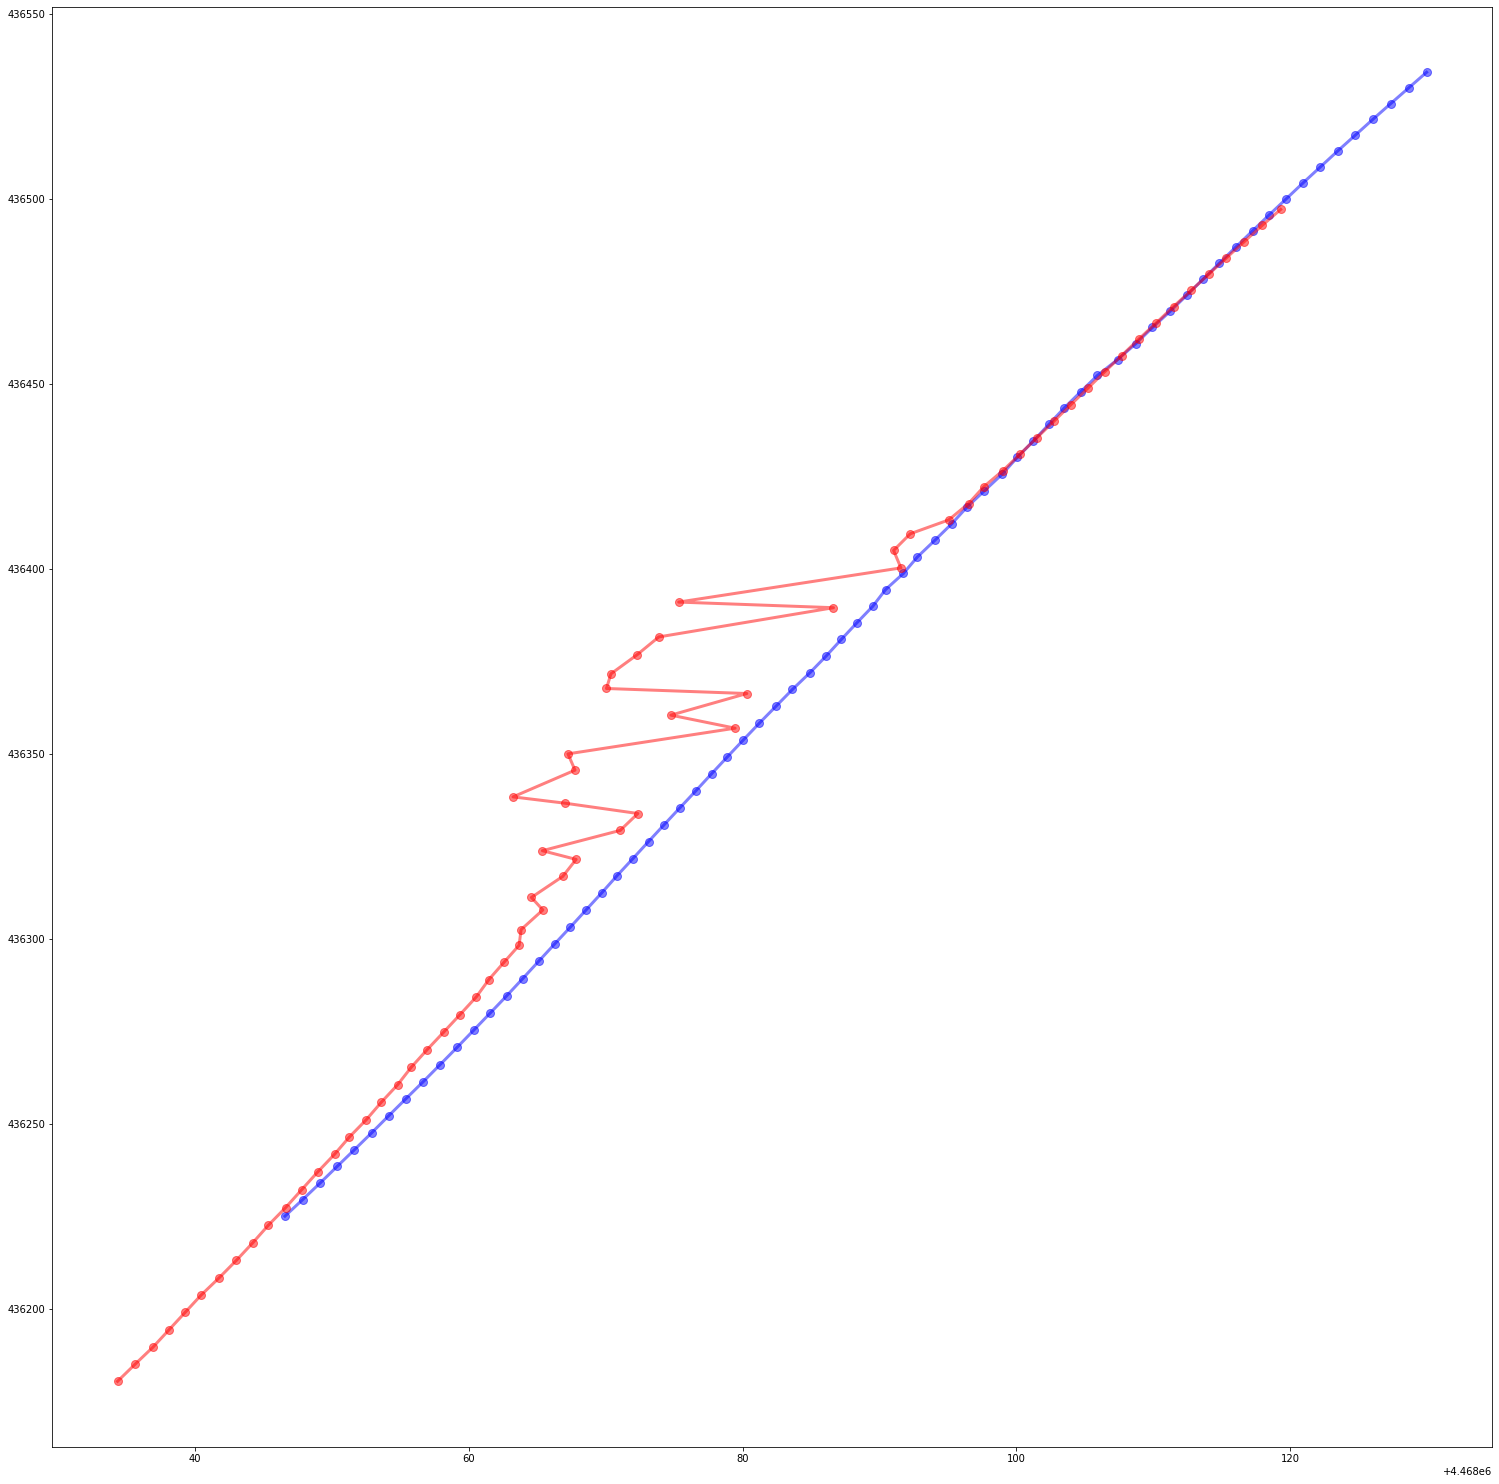

In [67]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[5115:5185]['North_Prediction(x)'],Prediction_DataFrame[5115:5185]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[5115:5185]['North'],Pos_DataFrame[5115:5185]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')